# How to trade multiple assets with a single strategy

Source of the code: https://backtest-rookies.com/2017/08/22/backtrader-multiple-data-feeds-indicators/

This is a nice tutorial which explains how to combine signals on multiple assets.

In [2]:
import backtrader as bt
from datetime import datetime

## Define the trading strategy

In [3]:
class maCross(bt.Strategy):
    '''
    Strategy using crossover between 40 and 200-day MAs.
    
    For an official backtrader blog on this topic please take a look at:
    https://www.backtrader.com/blog/posts/2017-04-09-multi-example/multi-example.html
    Also see this topic
    https://community.backtrader.com/topic/152/multi-asset-ranking-and-rebalancing/4?page=1

    oneplot = Force all datas to plot on the same master.
    '''
    params = (
    ('sma1', 40),
    ('sma2', 200),
    ('oneplot', True)
    )

    def __init__(self):
        '''
        Create an dictionary of indicators so that we can dynamically add the
        indicators to the strategy using a loop. This mean the strategy will
        work with any number of data feeds. 
        '''
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[d] = dict()
            self.inds[d]['sma1'] = bt.indicators.SimpleMovingAverage(
                d.close, period=self.params.sma1)
            self.inds[d]['sma2'] = bt.indicators.SimpleMovingAverage(
                d.close, period=self.params.sma2)
            # cross==1 if sma1 cross above sma2 / -1 if if sma1 cross below sma2
            self.inds[d]['cross'] = bt.indicators.CrossOver(self.inds[d]['sma1'],self.inds[d]['sma2'])

            if i > 0: #Check we are not on the first loop of data feed:
                if self.p.oneplot == True:
                    d.plotinfo.plotmaster = self.datas[0]

    def next(self):
        """
        This is were we define the trading strategy
        ----
        Before placing orders, we need to see if positions already exist on each stock
        I do not exactly understand how it works but that's a good start
        """
        # Loop over each dataset
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            # pos stores current size of the position on this asset
            pos = self.getposition(d).size
            # no market / no orders
            if not pos:  
                # Then buy 1000 shares on bullish crossover (long)
                if self.inds[d]['cross'][0] == 1:
                    self.buy(data=d, size=1000)
                # or sell 1000 shares on bearish crossover (short)
                elif self.inds[d]['cross'][0] == -1:
                    self.sell(data=d, size=1000)
            # means we have positions
            else:
                # case bullish crossover
                if self.inds[d]['cross'][0] == 1:
                    # liquidate (short?) positions
                    self.close(data=d)
                    # then buy
                    self.buy(data=d, size=1000)
                # case bearish crossover
                elif self.inds[d]['cross'][0] == -1:
                    # Liquidate (long?) position
                    self.close(data=d)
                    # then sell
                    self.sell(data=d, size=1000)

    def notify_trade(self, trade):
        dt = self.data.datetime.date()
        if trade.isclosed:
            print('{} {} Closed: PnL Gross {}, Net {}'.format(
                                                dt,
                                                trade.data._name,
                                                round(trade.pnl,2),
                                                round(trade.pnlcomm,2)))

## Explain how to read csv files

The 3 files used are store in the data folder of the repo.

In [ ]:
class OandaCSVData(bt.feeds.GenericCSVData):
    """
    Explain format of csv files used
    ----
    Seems to be a file downloaded from Oanda API
    """
    params = (
        ('nullvalue', float('NaN')),
        ('dtformat', '%Y-%m-%dT%H:%M:%S.%fZ'),
        ('datetime', 6),
        ('time', -1),
        ('open', 5),
        ('high', 3),
        ('low', 4),
        ('close', 1),
        ('volume', 7),
        ('openinterest', -1),
    )

## Run the backtest

2005-12-02 GBPAUD Closed: PnL Gross -15.15, Net -15.15
2006-01-10 GBPAUD Closed: PnL Gross -40.15, Net -40.15
2006-02-21 EURUSD Closed: PnL Gross -12.77, Net -12.77
2006-04-02 EURUSD Closed: PnL Gross -20.32, Net -20.32
2006-09-22 CADCHF Closed: PnL Gross -26.16, Net -26.16
2006-10-24 EURUSD Closed: PnL Gross 44.22, Net 44.22
2006-11-21 GBPAUD Closed: PnL Gross 104.3, Net 104.3
2006-11-24 EURUSD Closed: PnL Gross -53.58, Net -53.58
2006-11-25 CADCHF Closed: PnL Gross -40.66, Net -40.66
2006-12-06 GBPAUD Closed: PnL Gross -45.9, Net -45.9
2007-03-18 GBPAUD Closed: PnL Gross -63.55, Net -63.55
2007-05-07 CADCHF Closed: PnL Gross -33.81, Net -33.81
2007-09-03 GBPAUD Closed: PnL Gross -8.46, Net -8.46
2007-10-03 GBPAUD Closed: PnL Gross -150.34, Net -150.34
2007-12-13 CADCHF Closed: PnL Gross 18.43, Net 18.43
2008-08-25 EURUSD Closed: PnL Gross 166.2, Net 166.2
2008-08-28 GBPAUD Closed: PnL Gross 180.29, Net 180.29
2008-09-08 CADCHF Closed: PnL Gross 55.03, Net 55.03
2008-10-22 CADCHF Clos

<IPython.core.display.Javascript object>


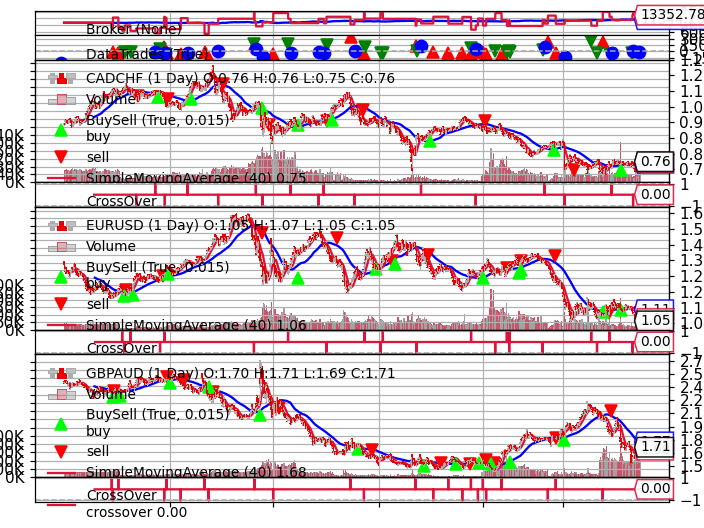

[[<Figure size 640x480 with 11 Axes>]]

In [1]:
# Variable for our starting cash
startcash = 10000

# Create an instance of cerebro
cerebro = bt.Cerebro()

# Add our strategy
cerebro.addstrategy(maCross, oneplot=False)

# Create our data list
# [0] = Data file, [1] = Data name
datalist = [
    ('data/CAD_CHF-2005-2017-D1.csv', 'CADCHF'), 
    ('data/EUR_USD-2005-2017-D1.csv', 'EURUSD'),
    ('data/GBP_AUD-2005-2017-D1.csv', 'GBPAUD'),
]

#Loop through the list adding to cerebro.
for i in range(len(datalist)):
    data = OandaCSVData(dataname=datalist[i][0])
    cerebro.adddata(data, name=datalist[i][1])


# Set our desired cash start
cerebro.broker.setcash(startcash)

# Run over everything
cerebro.run()

#Get final portfolio Value
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash

#Print out the final result
print('Final Portfolio Value: ${}'.format(portvalue))
print('P/L: ${}'.format(pnl))

#Finally plot the end results
cerebro.plot(style='candlestick')